# Loading main model

In [1]:
import numpy as np
import os
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, LayerNormalization, Permute, Reshape, GaussianNoise, LSTM, Bidirectional

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.98
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

include_init25s = False
# 처음 25초를 outcome에 포함시켜서 input과 같은 길이를 얻으려면 True
# 처음 25초를 outcome에서 제외하려면 False

In [2]:
FrameSize = 50
OverlapSize = 10 # actually, frame interval

InpL = Input(shape=(3000,))

InpFrame = tf.signal.frame(InpL, FrameSize, OverlapSize)
InpFrameNoise = GaussianNoise(0.0)(InpFrame)

Encoder = Dense(50, activation='relu', name = 'Encoder1')(InpFrameNoise)
Encoder = Dropout(0.0)(Encoder, training=True)

Encoder = Bidirectional(LSTM(25, return_sequences=True))(Encoder)
Att_front = Bidirectional(LSTM(5, return_sequences=True))(Encoder)
Att_front = LayerNormalization(axis=(1), epsilon=0.001)(Att_front)
Att_front = Permute((2,1))(Att_front)
Att_front = Dropout(0.0)(Att_front, training=True)
Att_front = Dense(InpFrame.shape[1],activation='softmax')(Att_front)
Att_front = Permute((2,1), name='Att_front')(Att_front)

Context = InpFrameNoise[:,:,None] * Att_front[:,:,:,None]
Context = tf.reduce_sum(Context, axis=(1), name = 'Context')

Decoder = Bidirectional(LSTM(25, return_sequences=True))(Context)
Decoder = LayerNormalization(axis=(1,2), epsilon=0.001)(Decoder)

Att_back = Bidirectional(LSTM(250, return_sequences=False))(InpFrame)
Att_back = Reshape((10, 50))(Att_back)
Att_back = LayerNormalization(axis=(1,2), epsilon=0.001)(Att_back)
Att_back = Bidirectional(LSTM(25, return_sequences=True))(Att_back)
Att_back = Dropout(0.0)(Att_back, training=True)
Att_back = Dense(50,activation='tanh')(Att_back)

Scaling = Decoder + Att_back
Scaling = Bidirectional(LSTM(25, return_sequences=True, name = 'Scaling'))(Scaling)

ValDecoder = Context + Scaling
ABPOut= Reshape((-1,),name='ABPOut')(ValDecoder)
ABPOut_diff = Reshape((-1,),name='ABPOut_diff')(ABPOut[:,1:]-ABPOut[:,:-1])

Casted = tf.cast(ABPOut, tf.complex64) 
fft = tf.signal.fft(Casted)[:, :(Casted.shape[-1]//2+1)]
AmplitudeOut = tf.abs(fft[:,1:])*(1/(fft.shape[-1])) 
AmplitudeOut= Reshape((-1,),name='AmplitudeOut')(AmplitudeOut)

AE_ABP_ABPd_AMP = Model(InpL, (ABPOut, ABPOut_diff, AmplitudeOut))

AE_ABP_ABPd_AMP.load_weights('AE_ABP_ABPd_AMP.hdf5')

# Loading data
- For downstream task

In [3]:
# downstream task의 input data
filename = 'abp_input_sample.npy'
abp_input = np.load(filename) # (length, time)의 shape 가정, normalize 가정
print(f'Shape of input data: {abp_input.shape}')

Shape of input data: (100, 9000)


# Generating cleansed data
- Outcome of cleansing model

In [4]:
batch = 50

In [5]:
# batch 단위로 prediction
for n in range(abp_input.shape[0]//batch):
    
    # 0~30초를 입력으로 25~30초 prediction
    Pred = AE_ABP_ABPd_AMP.predict(abp_input[batch*n:batch*(n+1),:3000])[0]
    
    # ABP input의 25~30초를 Pred로 대체
    x = np.concatenate((abp_input[batch*n:batch*(n+1),:2500], Pred), axis=1)
    
    if include_init25s == True:
        # ABP input의 처음 25초 포함
        outsig_entire_time = x.copy()
    else:
        # ABP input의 처음 25초 제외
        outsig_entire_time = Pred.copy()
    
    # Sliding prediction, ABP input 5초씩 새로 결합하여 prediction
    for i in range(1,(abp_input.shape[1]-2500)//500):
        
        # x의 후반 25초에 ABP input 5초를 새로 결합
        x_h = np.concatenate((x[:,500:], abp_input[batch*n:batch*(n+1),3000+500*(i-1):3000+500*i]), axis=1)
        
        # 만약 nan이 있다면 0으로 대체
        if np.sum(np.isnan(x_h)) > 0:
            x_h = np.where(np.isnan(x_h), 0.0, x_h)
        
        # x_h를 입력으로 후반부 5초 prediction
        Pred = AE_ABP_ABPd_AMP.predict(x_h)[0]
        
        # Pred로 기존 데이터 대체
        x = np.concatenate((x_h[:,:2500], Pred), axis=1)
        
        # 새로운 Pred를 계속해서 결합
        outsig_entire_time = np.concatenate((outsig_entire_time, Pred), axis=1)
        
    # batch 단위로 결합
    if n == 0:
        outsig_entire_data_ABP_ABPd_AMP = outsig_entire_time.copy()
    else:
        outsig_entire_data_ABP_ABPd_AMP = np.concatenate((outsig_entire_data_ABP_ABPd_AMP, outsig_entire_time), axis=0)
    
    print(f'{outsig_entire_data_ABP_ABPd_AMP.shape[0]} / {abp_input.shape[0]}')
    clear_output(wait=True)
print(f'{outsig_entire_data_ABP_ABPd_AMP.shape[0]} / {abp_input.shape[0]} -- AE_ABP_ABPd_AMP prediction complete')

100 / 100 -- AE_ABP_ABPd_AMP prediction complete


### Plot

In [6]:
import matplotlib.pyplot as plt

Signal ID: 0


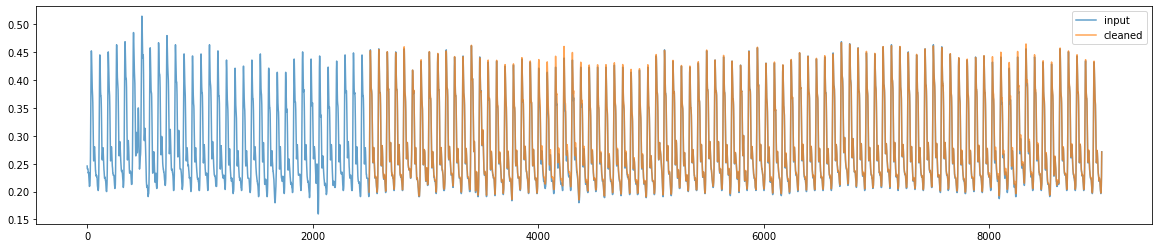

Signal ID: 3


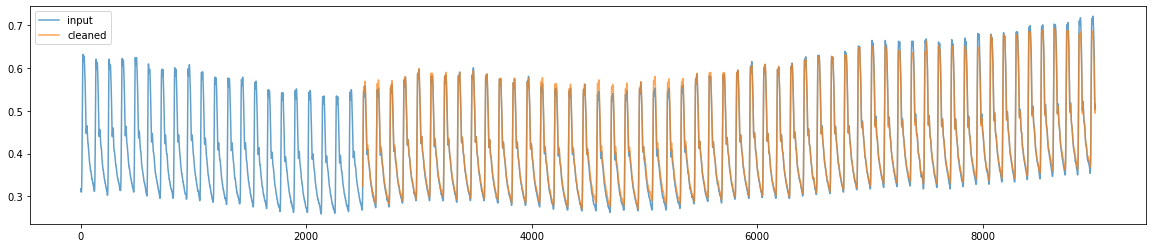

Signal ID: 6


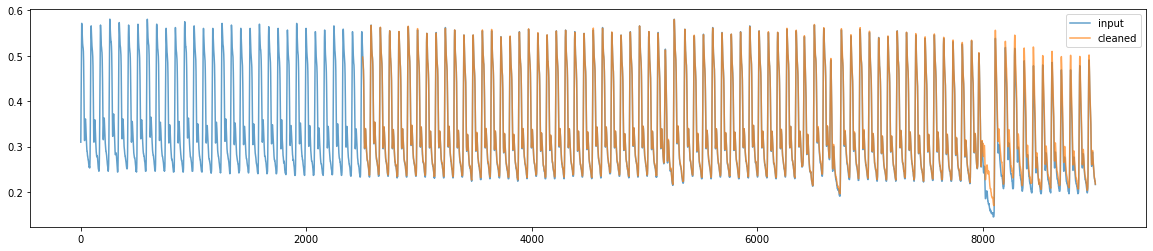

Signal ID: 9


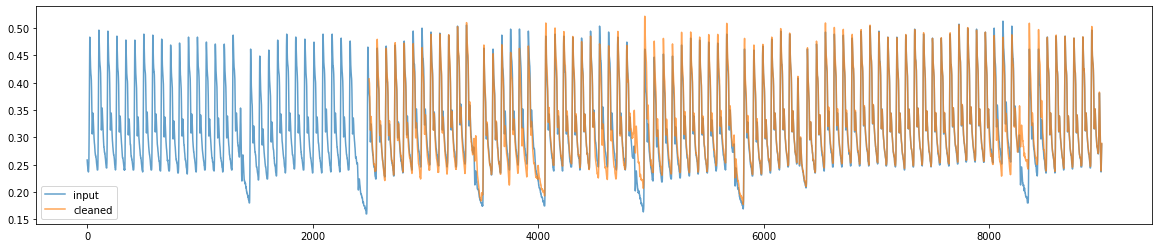

Signal ID: 12


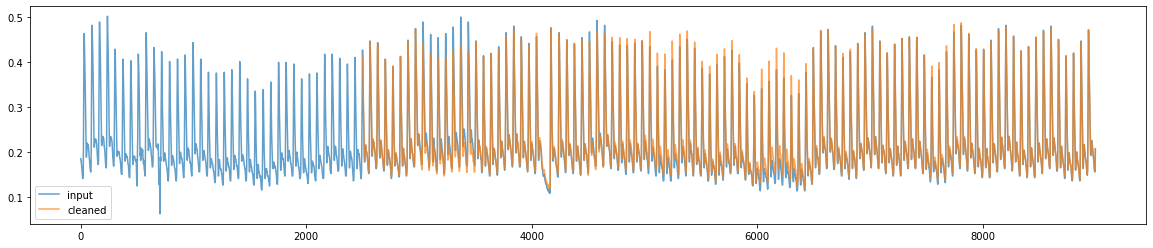

Signal ID: 15


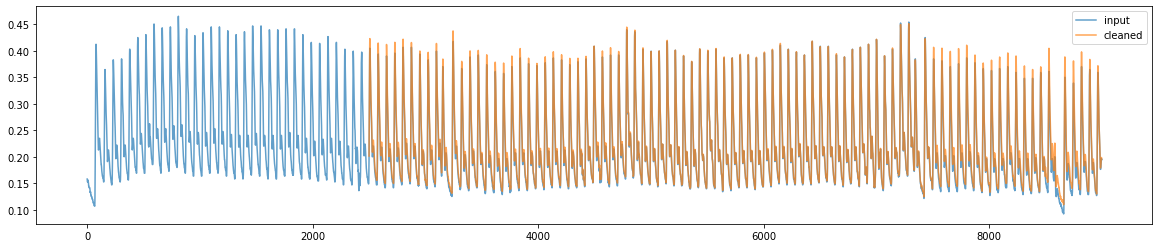

Signal ID: 18


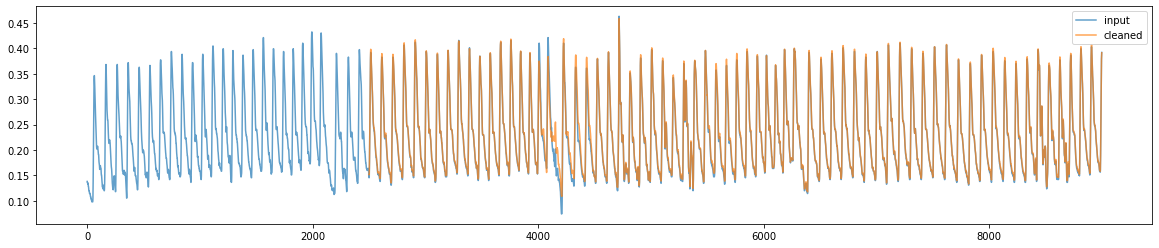

Signal ID: 21


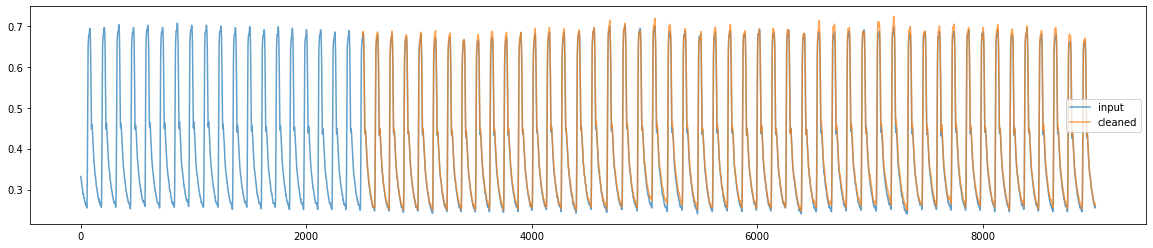

Signal ID: 24


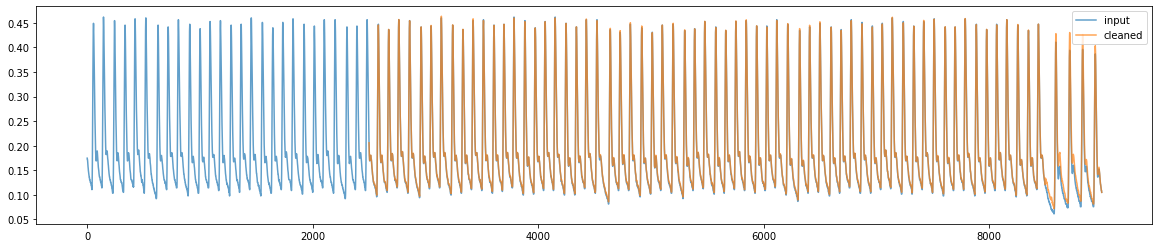

Signal ID: 27


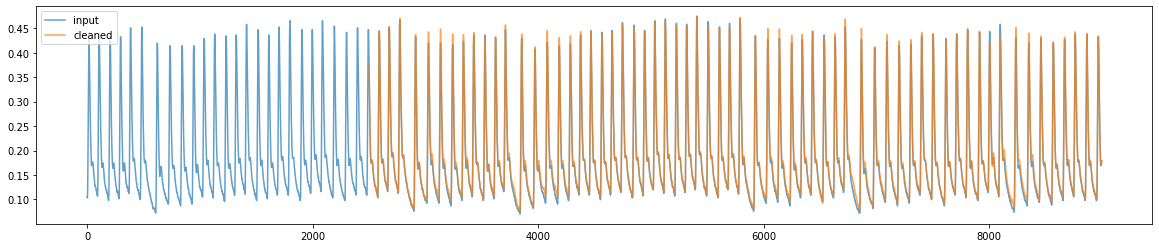

Signal ID: 30


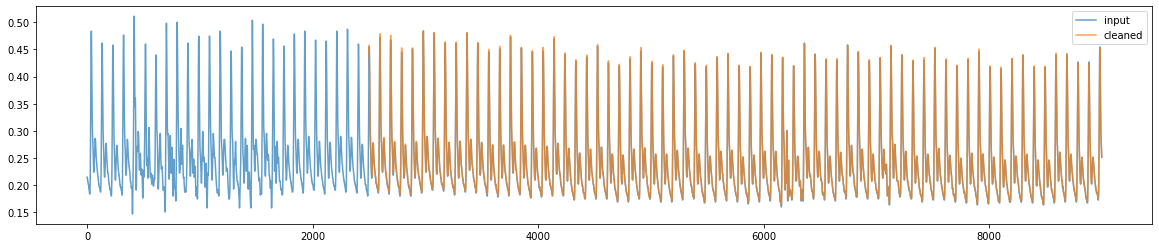

Signal ID: 33


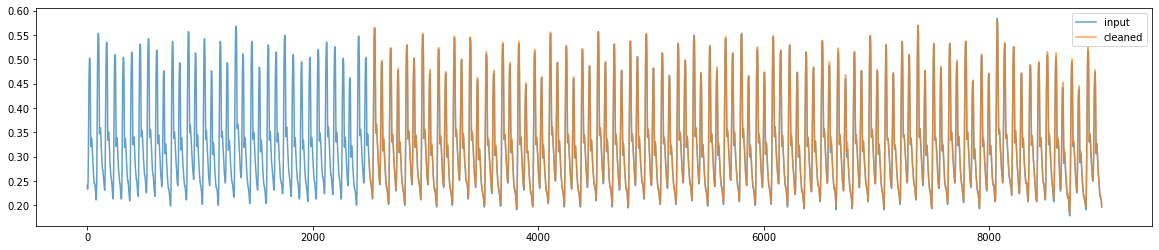

Signal ID: 36


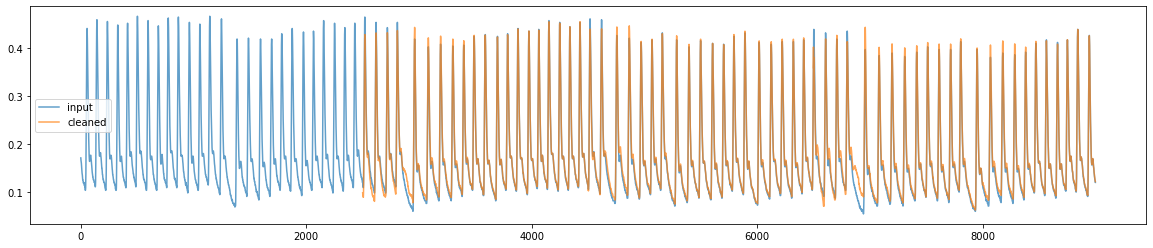

Signal ID: 39


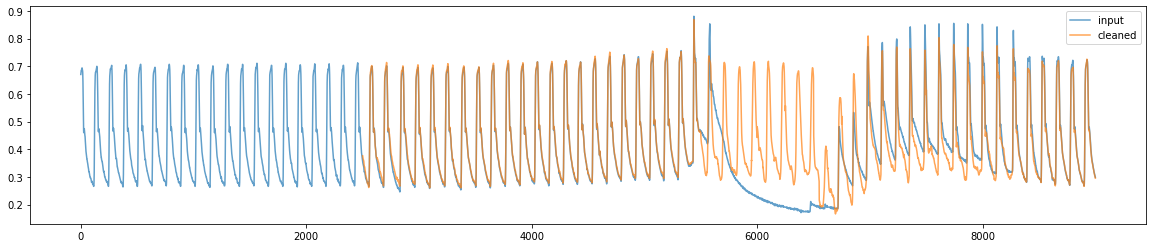

Signal ID: 42


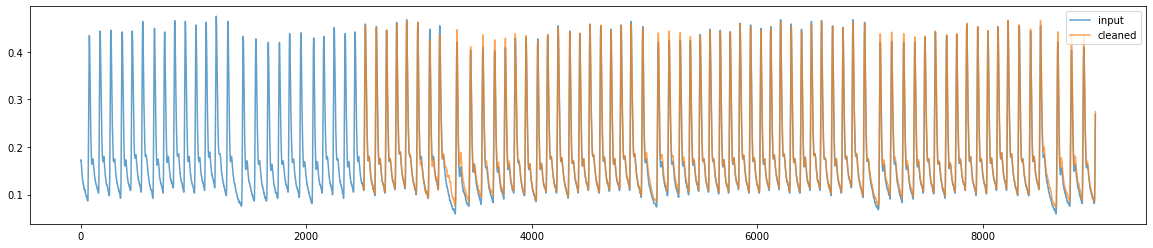

Signal ID: 45


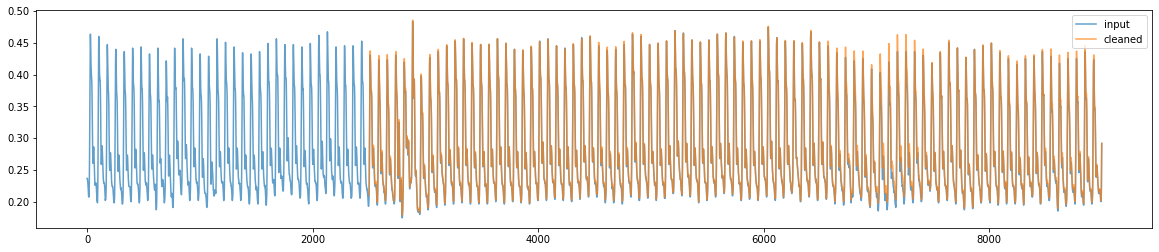

Signal ID: 48


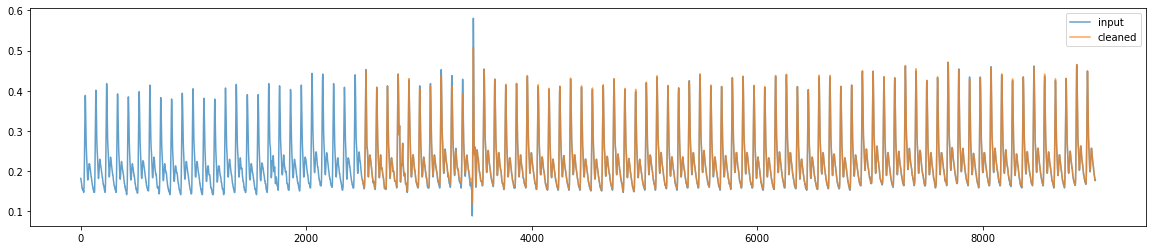

Signal ID: 51


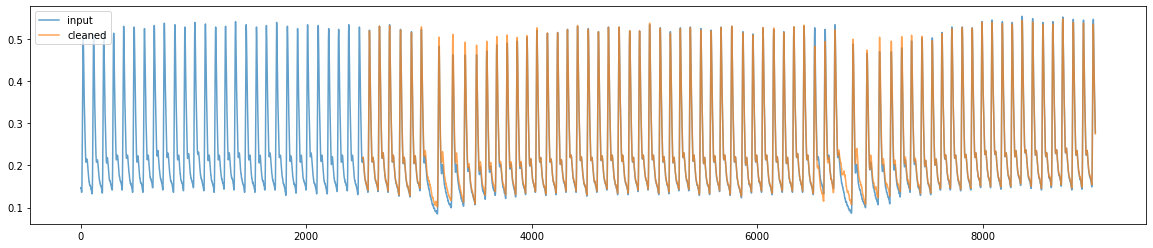

Signal ID: 54


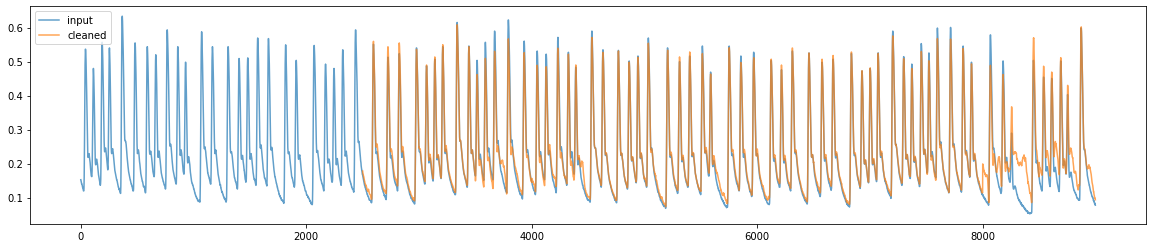

Signal ID: 57


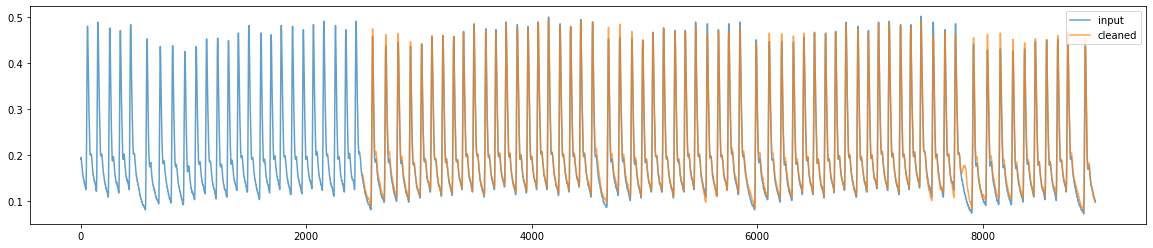

Signal ID: 60


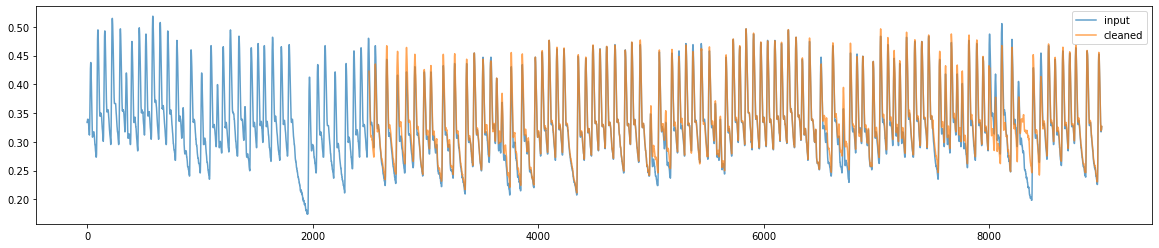

Signal ID: 63


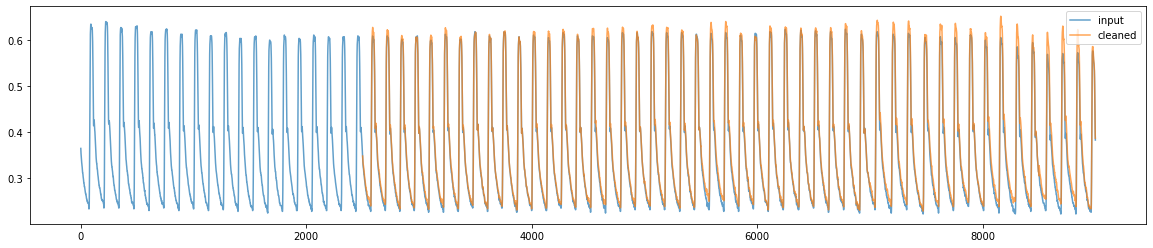

Signal ID: 66


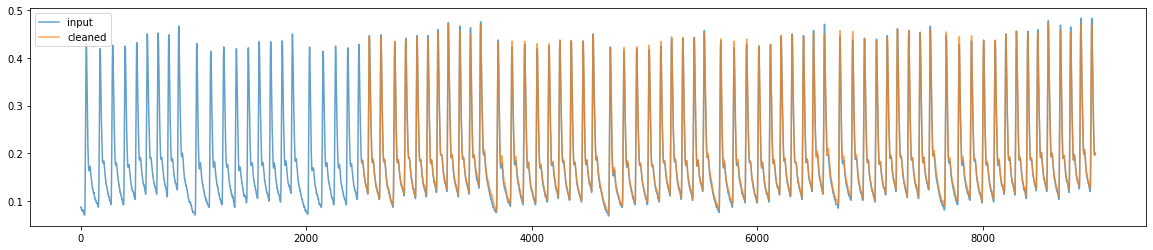

Signal ID: 69


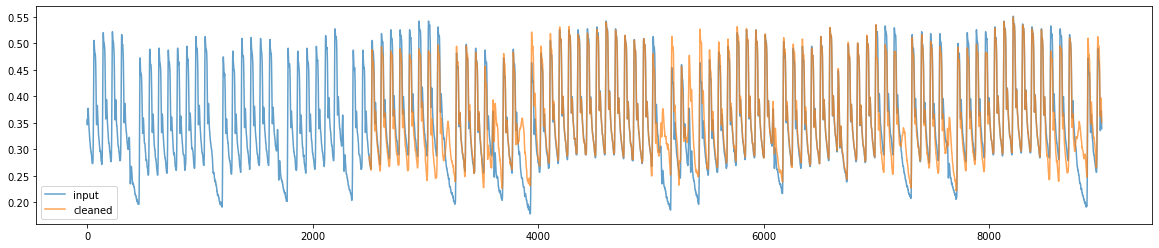

Signal ID: 72


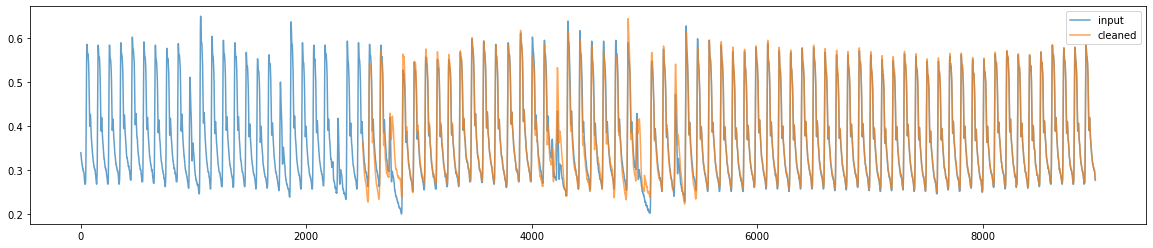

Signal ID: 75


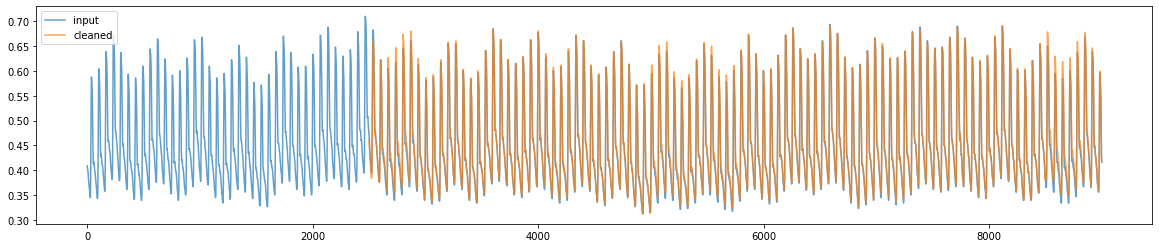

Signal ID: 78


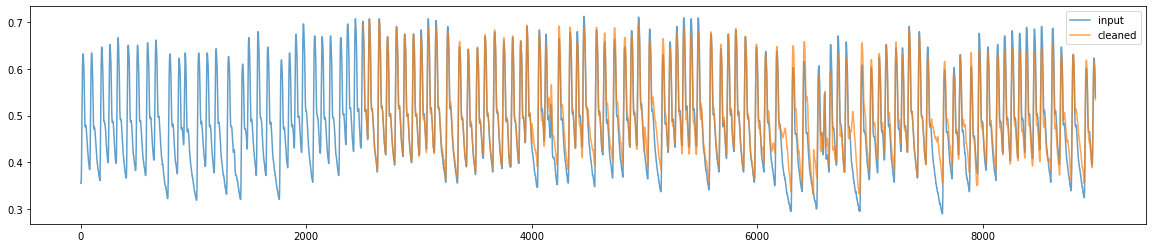

Signal ID: 81


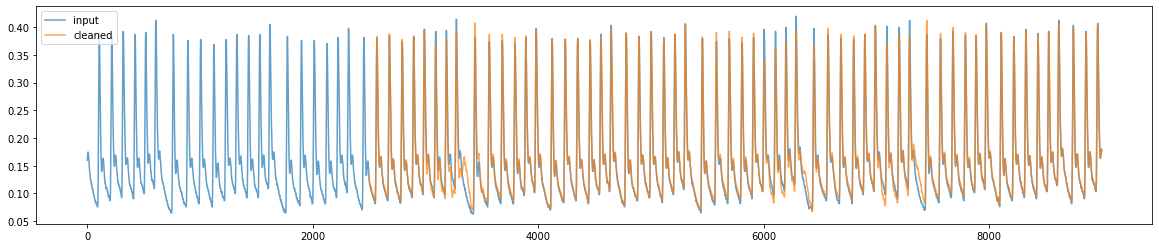

Signal ID: 84


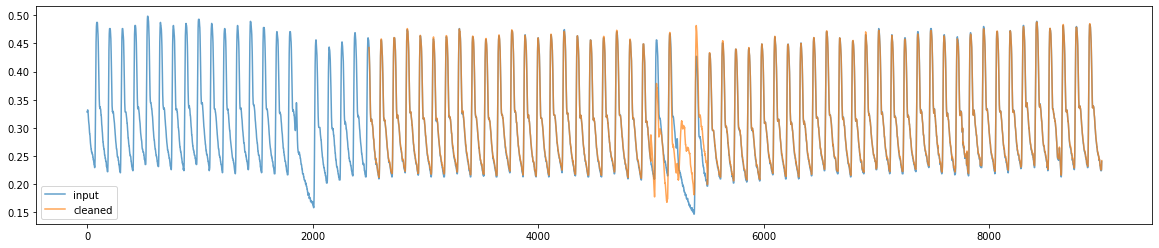

Signal ID: 87


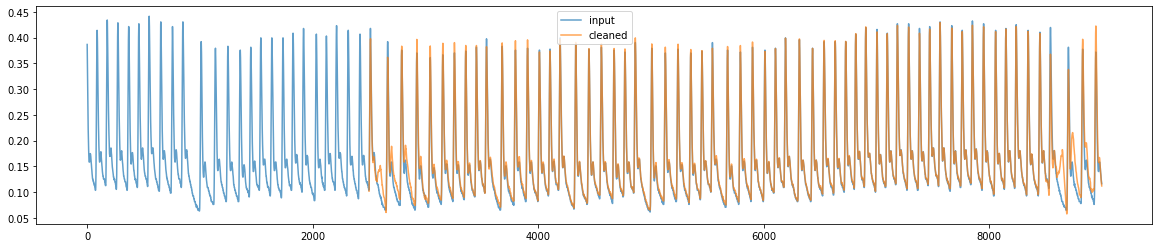

Signal ID: 90


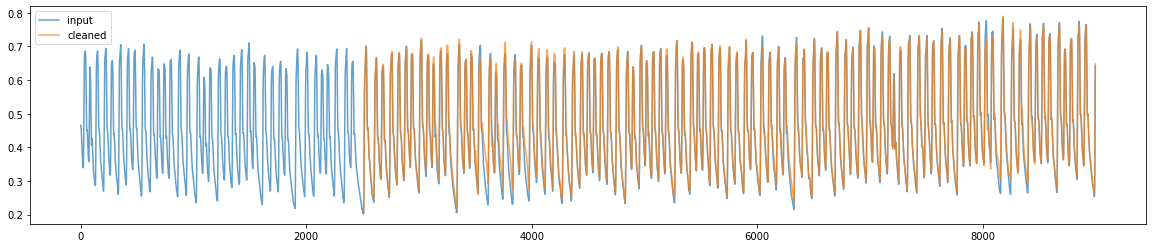

Signal ID: 93


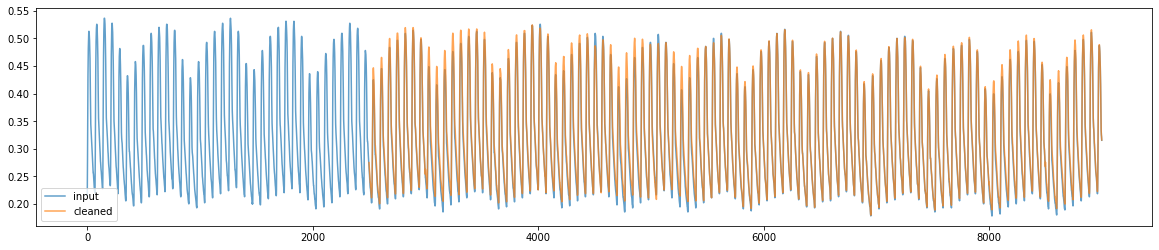

Signal ID: 96


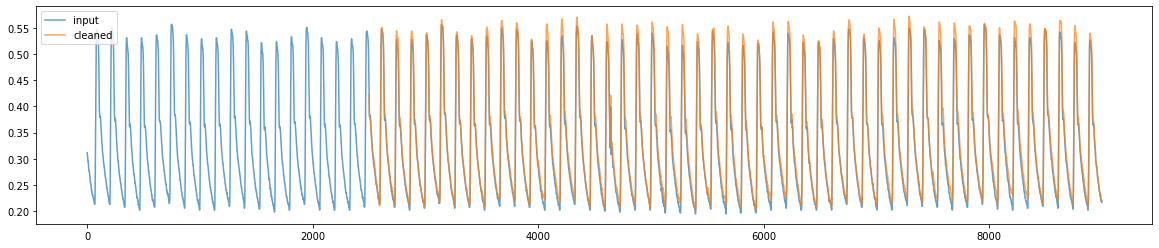

Signal ID: 99


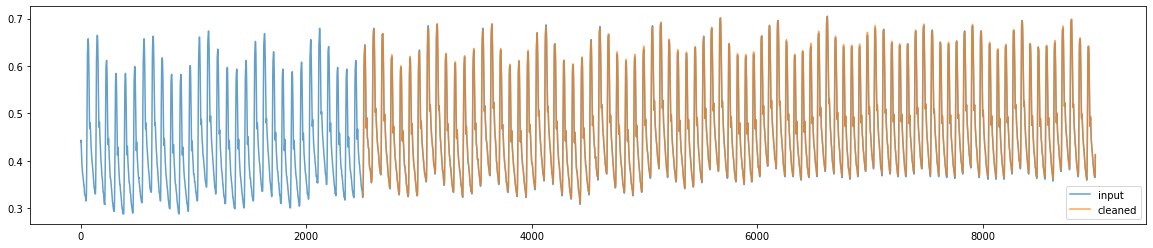

In [7]:
for i in range(0,len(abp_input),3):
    print(f'Signal ID: {i}')
    plt.figure(figsize=(20,4))
    plt.plot(abp_input[i], alpha=0.7, label='input')
    plt.plot(range(2500,abp_input.shape[1]),outsig_entire_data_ABP_ABPd_AMP[i], alpha=0.7, label='cleaned')
    plt.legend()
    plt.show()